In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [2]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Convolution forward pass

Implement convolution forward pass: append your code after TODO. Don’t forget about bias

In [3]:
def conv_forward_naive(x, w, b, conv_param):
    """A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']
    H_out = 1 + (H + 2 * pad - HH) // stride
    W_out = 1 + (W + 2 * pad - WW) // stride
    out = np.zeros((N, F, H_out, W_out))
    x_pad = np.pad(x, ((0,0), (0,0), (pad, pad), (pad, pad)), 'constant')
    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    out[n, f, i, j] = np.sum(x_pad[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW] * w[f, :]) + b[f]

    cache = (x, w, b, conv_param)
    return out, cache

In [4]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


In [5]:
from PIL import Image
from imageio import imread

In [6]:
kitten = Image.open('pictures/kitten.jpg')
puppy = Image.open('pictures/puppy.jpg')

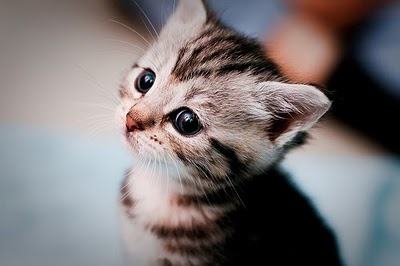

In [7]:
kitten

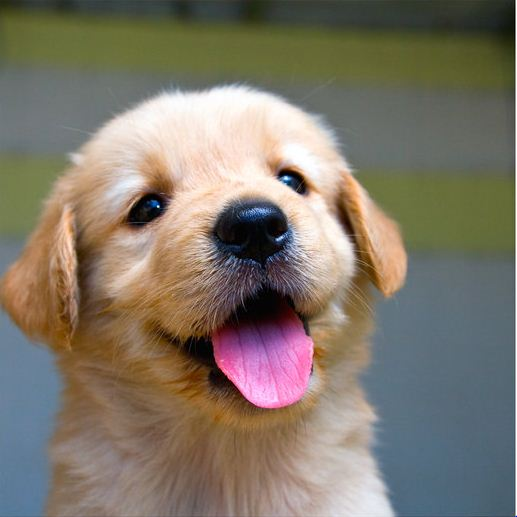

In [8]:
puppy

In [9]:
print(f"Kitten shape: {kitten.size}")
print(f"Puppy shape: {puppy.size}")

Kitten shape: (400, 266)
Puppy shape: (517, 517)


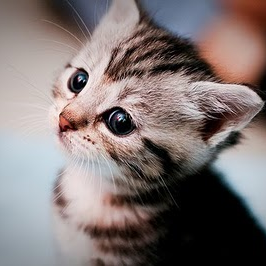

In [10]:
# kitten is wide, and puppy is already square
d = kitten.size[0] - kitten.size[1]
kitten_cropped = kitten.crop([d // 2, 0, kitten.size[0] - d// 2, kitten.size[1]])
kitten_cropped

In [11]:
print(f"Kitten cropped shape: {kitten_cropped.size}")

Kitten cropped shape: (266, 266)


In [ ]:
img_size = 200   # Make this smaller if it runs too slow and convert to np.array
resized_puppy = np.array(puppy.resize((img_size, img_size)))
resized_kitten = np.array(kitten_cropped.resize((img_size, img_size)))


# make a batch of input images
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

# Second filter detects horisontal edges in the blue channel.
w[1, 2, :, :] = [[1, 1, 1],
                 [0, 0, 0],
                 [-1, -1, -1]]


# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})


def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

    
def plot_images(_out, img_1, img_2):
    """ Show the original images and the results of the conv operation """
    plt.subplot(2, 3, 1)
    imshow_no_ax(np.array(img_1), normalize=False)
    plt.title('Original image')
    plt.subplot(2, 3, 2)
    imshow_no_ax(_out[0, 0])
    plt.title('Grayscale')
    plt.subplot(2, 3, 3)
    imshow_no_ax(_out[0, 1])
    plt.title('Edges')
    plt.subplot(2, 3, 4)
    imshow_no_ax(np.array(img_2), normalize=False)
    plt.subplot(2, 3, 5)
    imshow_no_ax(_out[1, 0])
    plt.subplot(2, 3, 6)
    imshow_no_ax(_out[1, 1])
    plt.show()

    
plot_images(out, puppy, kitten_cropped)

Trying to convert horizontal edges filter to vertical ones

In [ ]:
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]

# Second filter detects vertical edges in the blue channel.
w[1, 2, :, :] = [[1, 0, -1],
                 [1, 0, -1],
                 [1, 0, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

plot_images(out, puppy, kitten_cropped)